In [1]:
import anthropic
anthropic_client = anthropic.Anthropic(api_key=open('ANTHROPIC_API_KEY.txt').read().strip())

import re
import os
from sklearn.metrics import accuracy_score
import sys
import multiprocessing
from multiprocessing import Process
import concurrent.futures
from tqdm.notebook import tqdm
# import metaomni as mo

import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits, fetch_california_housing, fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.base import BaseEstimator
from typing import List, Tuple, Dict, Union

import traceback
import os
import importlib.util
import time

import importlib
sys.path.append('/Users/jeremynixon/Dropbox/python_new/Misc/omega_research/metaomni')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# Load the Wine dataset
wine = load_wine()
X, y = wine.data, wine.target

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
def gen(prompt):
    message = anthropic_client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=4000,
        temperature=0,
        system="You are a world-class research engineer.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    )
    return message.content[0].text

def extract_code_snippets(text):
    pattern = r'```(?:python)?\n(.*?)```'
    snippets = re.findall(pattern, text, re.DOTALL)
    return [snippet.strip() for snippet in snippets]

def save_first_snippet(snippets, filename):
    if snippets:
        with open(filename, 'w') as file:
            file.write(snippets[0])
        print(f"First code snippet saved to {filename}")
    else:
        print("No code snippets found")

def extract_name(text):
    pattern = r'<name>(.*?)</name>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return None

# Dataset Evaluation

In [5]:

from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

# from sklearn.model_selection import train_test_split

# iris = load_iris()
# X, y = iris.data, iris.target
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# from sklearn.model_selection import train_test_split

# # Load the Wine dataset
# wine = load_wine()
# X, y = wine.data, wine.target

# # Split the dataset into training and testing sets
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def gen(prompt):
    message = anthropic_client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=4000,
        temperature=0,
        system="You are a world-class research engineer.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    )
    return message.content[0].text

def extract_code_snippets(text):
    pattern = r'```(?:python)?\n(.*?)```'
    snippets = re.findall(pattern, text, re.DOTALL)
    return [snippet.strip() for snippet in snippets]

def save_first_snippet(snippets, filename):
    if snippets:
        with open(filename, 'w') as file:
            file.write(snippets[0])
        print(f"First code snippet saved to {filename}")
    else:
        print("No code snippets found")

def extract_name(text):
    pattern = r'<name>(.*?)</name>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return None

def add_import_to_init(init_file_path, import_string):
    # Read the current contents of the file
    with open(init_file_path, 'r') as file:
        content = file.read()

    # Check if the import statement already exists
    if import_string not in content:
        # If it doesn't exist, add it to the end of the file
        with open(init_file_path, 'a') as file:
            file.write('\n' + import_string)
        print(f"Added {import_string} to {init_file_path}")
    else:
        print(f"{import_string} already exists in {init_file_path}")

# model = 'logistic regression'

def execute(filename, class_name, model, count=1):
    if count > 2:
        try:
            os.remove(filename)
            return
        except:
            pass
    
    EXECUTION_STRINGS = f"""importlib.reload(metaomni)
ml_model = metaomni.{filename.split('.py')[0]}.{class_name}()
ml_model.fit(x_train, y_train)
preds = ml_model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print(class_name, accuracy)"""
    
    try:
        exec(EXECUTION_STRINGS)
    except Exception as e:
        error_message = traceback.format_exc()
        print("Hit error: ", error_message)
        
        prompt = f"""
        Existing code:
        {open(f'metaomni/{filename}', 'r').read()}
    
        Error message on original execution:
        {e}
    
        Full traceback:
        {error_message}
    
        Given the original code and this error, rewrite a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
        implementation = gen(prompt)
        
        snippets = extract_code_snippets(implementation)
        save_first_snippet(snippets, 'metaomni/' + filename)
        execute(filename, class_name, model, count+1)

def genML(model):
    class_name_prompt = f"""Write a succinct pythonic class name for a model with name {model}, putting the name between the XML tags <name>Insert Class Name of Model Here</name>"""
    class_name = extract_name(gen(class_name_prompt))
    
    filename_prompt = f"""Write a succinct pythonic file name for a model with name {model}, putting the file name between the XML tags <name>Insert Class Name of File Here</name>"""
    filename = extract_name(gen(filename_prompt))
    
    import_string = f"import {filename.split('.py')[0]}"
    
    prompt = f"""Write a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
    implementation = gen(prompt)
    
    snippets = extract_code_snippets(implementation)
    save_first_snippet(snippets, 'metaomni/' + filename)
    add_import_to_init('metaomni/__init__.py', import_string)
    execute(filename, class_name, model, count=1)
    return (filename, class_name)

def parallel_genML(prompt_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(genML, prompt_list), total=len(prompt_list)))    

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, average_precision_score, cohen_kappa_score
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits, load_diabetes, fetch_california_housing, fetch_olivetti_faces, fetch_20newsgroups, fetch_covtype, fetch_kddcup99

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


def evaluate_model(model, dataset_name, test_size=0.2):
    if dataset_name == "Iris":
        data = load_iris()
    elif dataset_name == "Wine":
        data = load_wine()
    elif dataset_name == "Breast Cancer":
        data = load_breast_cancer()
    elif dataset_name == "Digits":
        data = load_digits()
    elif dataset_name == "Diabetes":
        data = load_diabetes()
    elif dataset_name == "California Housing":
        data = fetch_california_housing()
    elif dataset_name == "Olivetti Faces":
        data = fetch_olivetti_faces()
    # 20 Newsgroups returns text data in the result, even for classification
    # elif dataset_name == "20 Newsgroups":
    #     newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    #     return newsgroups.data, newsgroups.target
    elif dataset_name == "Covertype":
        data = fetch_covtype()
    elif dataset_name == "KDD Cup 1999":
        data = fetch_kddcup99()
    elif dataset_name == "Abalone":
        data = fetch_openml(name='abalone', version=1, as_frame=False)
    # Adult has NaNs
    # elif dataset_name == "Adult":
    #     data = fetch_openml('adult', version=2, as_frame=False)
    # MNIST is too slow, and is an image dataset
    # elif dataset_name == "MNIST":
    #     data = fetch_openml('mnist_784', version=1, as_frame=False)
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Initialize results dictionary
    results = {
        "dataset": dataset_name,
        "model": model.__class__.__name__,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm,
        "cohen_kappa": kappa,
        "cross_val_scores": cv_scores,
        "mean_cv_score": cv_scores.mean(),
        "cv_score_std": cv_scores.std()
    }
    
    # Calculate ROC AUC and Average Precision for binary classification
    if len(np.unique(y)) == 2:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        results["roc_auc"] = roc_auc_score(y_test, y_pred_proba)
        results["average_precision"] = average_precision_score(y_test, y_pred_proba)
    
    return results

# Example usage:
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
# 
# # Load data
# iris = load_iris()
# X, y = iris.data, iris.target
# 
# # Create and evaluate model
# model = LogisticRegression()
# results = evaluate_model(model, X, y, "Iris Dataset")
# 
# # Print results
# for key, value in results.items():
#     print(f"{key}: {value}")

In [21]:
# if dataset_name == "Iris":
iris = load_iris()
X, y = iris.data, iris.target
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standard Eval

In [13]:
import time
models = [
    ("Decision Tree", DecisionTreeClassifier()),
    # ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Support Vector Machine", SVC()),
    # ("Logistic Regression", LogisticRegression()),
    ("Gaussian Naive Bayes", GaussianNB())
]

dataset_names = [
    # "Iris",
    "Wine",
    "Breast Cancer",
    "Digits",
    "Diabetes",
    # "California Housing",
    # "Olivetti Faces",
    "Covertype",
    # "KDD Cup 1999",
    "Abalone"
]

table_overall = []

start = time.time()
for m in models:
    table_model = []
    print(m)
    print("Time = ", time.time()-start)
    for d in dataset_names:
        try:
            result = evaluate_model(m[1], d)
            print("Succeeded at :", d, result['accuracy'])
            table_model.append(result['accuracy'])
        except Exception as e:
            print("Failed at ", d, "with error", e)
    table_overall.append(table_model)

('Decision Tree', DecisionTreeClassifier())
Time =  0.001516103744506836
Succeeded at : Wine 0.8888888888888888
Succeeded at : Breast Cancer 0.8888888888888888
Succeeded at : Digits 0.9722222222222222
Succeeded at : Diabetes 0.9444444444444444
Succeeded at : Covertype 0.8888888888888888
Succeeded at : Abalone 0.9444444444444444
('Gradient Boosting', GradientBoostingClassifier())
Time =  0.43578624725341797


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Wine 0.9722222222222222
Succeeded at : Breast Cancer 0.9722222222222222
Succeeded at : Digits 0.9166666666666666
Succeeded at : Diabetes 0.9722222222222222
Succeeded at : Covertype 0.8888888888888888


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Abalone 0.8333333333333334
('K-Nearest Neighbors', KNeighborsClassifier())
Time =  5.813526153564453
Succeeded at : Wine 0.6944444444444444
Succeeded at : Breast Cancer 0.6666666666666666
Succeeded at : Digits 0.6666666666666666
Succeeded at : Diabetes 0.6666666666666666
Succeeded at : Covertype 0.5833333333333334
Succeeded at : Abalone 0.6666666666666666
('Support Vector Machine', SVC())
Time =  6.269675970077515
Succeeded at : Wine 0.5833333333333334
Succeeded at : Breast Cancer 0.6111111111111112
Succeeded at : Digits 0.6666666666666666
Succeeded at : Diabetes 0.7777777777777778


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Covertype 0.7777777777777778
Succeeded at : Abalone 0.6111111111111112
('Gaussian Naive Bayes', GaussianNB())
Time =  6.68185019493103
Succeeded at : Wine 0.9722222222222222
Succeeded at : Breast Cancer 1.0
Succeeded at : Digits 1.0
Succeeded at : Diabetes 0.9444444444444444


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Covertype 1.0
Succeeded at : Abalone 0.9722222222222222


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Latex Conversion

In [86]:
import pandas as pd
table_df = pd.DataFrame(table_overall)
table_df.columns = dataset_names
table_df.index = [m[0] for m in models]
latex_table = table_df.to_latex(index=False)
# To save the LaTeX table to a file:
with open('table2.tex', 'w') as f:
    f.write(latex_table)

/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_33383/4080202410.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_df.to_latex(index=False)


In [ ]:
[m[0] for m in models]

# AlgoGen KNN Eval

In [121]:
models = [
    ('KNeighborsClassifier', mo.KNeighborsClassifier()),
    # ('BalancedSimDissimKNN', mo.BalancedSimDissimKNN()),
    # ('BiasVarianceOptimizedKNNEnsemble', mo.BiasVarianceOptimizedKNNEnsemble()),
    # ('CompressibilitySimilarityKNN', mo.CompressibilitySimilarityKNN()),
    # ('DirectionalWeightedKNN', mo.DirectionalWeightedKNN()),
    # ('EntropyGuidedKNN', mo.EntropyGuidedKNN()),
    ('HybridKNNClassifier', mo.HybridKNNClassifier()),
    # ('InteractionAwareKNN', mo.InteractionAwareKNN()),
    ('MultiLevelAbstractionKNN', mo.MultiLevelAbstractionKNN()),
]


In [122]:
# models = [
#     ("Decision Tree", DecisionTreeClassifier()),
#     # ("Random Forest", RandomForestClassifier()),
#     ("Gradient Boosting", GradientBoostingClassifier()),
#     ("K-Nearest Neighbors", KNeighborsClassifier()),
#     ("Support Vector Machine", SVC()),
#     ("Logistic Regression", LogisticRegression()),
#     ("Gaussian Naive Bayes", GaussianNB())
# ]

dataset_names = [
    # "Iris",
    "Wine",
    "Breast Cancer",
    "Digits",
    "Diabetes",
    # "California Housing",
    # "Olivetti Faces",
    "Covertype",
    # "KDD Cup 1999",
    "Abalone"
]

table_overall = []

start = time.time()
for m in models:
    table_model = []
    print(m)
    print("Time = ", time.time()-start)
    for d in dataset_names:
        try:
            result = evaluate_model(m[1], d)
            print("Succeeded at :", d, result['accuracy'])
            table_model.append(result['accuracy'])
        except Exception as e:
            print("Failed at ", d, "with error", e)
            table_model.append(0.0)
    table_overall.append(table_model)

('KNeighborsClassifier', KNeighborsClassifier())
Time =  0.002562999725341797
Succeeded at : Wine 0.75
Succeeded at : Breast Cancer 0.6666666666666666
Succeeded at : Digits 0.6666666666666666
Succeeded at : Diabetes 0.6666666666666666
Succeeded at : Covertype 0.6666666666666666
Succeeded at : Abalone 0.6111111111111112
('HybridKNNClassifier', HybridKNNClassifier())
Time =  0.43250203132629395


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Wine 1.0
Succeeded at : Breast Cancer 1.0
Succeeded at : Digits 0.9444444444444444
Succeeded at : Diabetes 1.0
Succeeded at : Covertype 0.9722222222222222


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Succeeded at : Abalone 0.9166666666666666
('MultiLevelAbstractionKNN', MultiLevelAbstractionKNN(abstraction_ratios=[0.1, 0.3, 1.0]))
Time =  9.803020000457764
Succeeded at : Wine 0.9444444444444444
Succeeded at : Breast Cancer 0.8888888888888888
Succeeded at : Digits 0.9166666666666666
Succeeded at : Diabetes 0.9722222222222222
Succeeded at : Covertype 0.9444444444444444
Succeeded at : Abalone 1.0


/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [123]:
import pandas as pd
table_df = pd.DataFrame(table_overall)
table_df.columns = dataset_names
table_df.index = [m[0] for m in models]
latex_table = table_df.to_latex(index=False)
# To save the LaTeX table to a file:
with open('table_knn.tex', 'w') as f:
    f.write(latex_table)

/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_33383/3959434342.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = table_df.to_latex(index=False)


In [124]:
table_result = gen(latex_table + '\n given this latex table, reduce the number of digits after the decimal to 3, and add row labels according to: ' + str([m[0] for m in models]))
print(table_result)

Here's the modified LaTeX table with reduced decimal places and added row labels:

\begin{tabular}{lrrrrrr}
\toprule
Classifier & Wine & Breast Cancer & Digits & Diabetes & Covertype & Abalone \\
\midrule
KNeighborsClassifier & 0.750 & 0.667 & 0.667 & 0.667 & 0.667 & 0.611 \\
HybridKNNClassifier & 1.000 & 1.000 & 0.944 & 1.000 & 0.972 & 0.917 \\
MultiLevelAbstractionKNN & 0.944 & 0.889 & 0.917 & 0.972 & 0.944 & 1.000 \\
\bottomrule
\end{tabular}


In [44]:
# evaluate_model(LogisticRegression(), "20 Newsgroups")

In [47]:
from sklearn.neighbors import KNeighborsClassifier

result = evaluate_model(KNeighborsClassifier(), "Wine")

In [48]:
result_n = evaluate_model(KNeighborsClassifier(), "20 Newsgroups")

In [60]:
result['accuracy']

0.6666666666666666

In [61]:
result_n['accuracy']

TypeError: tuple indices must be integers or slices, not str

# Essential MetaOmni Functions

# Initial experiments

In [4]:
model = 'K-nearest-neighbors'
class_name_prompt = f"""Write a succinct pythonic class name for a model with name {model}, putting the name between the XML tags <name>Insert Class Name of Model Here</name>"""
class_name = extract_name(gen(class_name_prompt))

In [45]:
file_name_prompt = f"""Write a succinct pythonic file name for a model with name {model}, putting the file name between the XML tags <name>Insert Class Name of File Here</name>"""
file_name = extract_name(gen(file_name_prompt))

In [48]:
import_string = f"import {file_name.split('.py')[0]}"

In [50]:
import_string

'import knn_model'

In [53]:
model = 'logistic regression'

class_name_prompt = f"""Write a succinct pythonic class name for a model with name {model}, putting the name between the XML tags <name>Insert Class Name of Model Here</name>"""
class_name = extract_name(gen(class_name_prompt))

filename_prompt = f"""Write a succinct pythonic file name for a model with name {model}, putting the file name between the XML tags <name>Insert Class Name of File Here</name>"""
filename = extract_name(gen(filename_prompt))

import_string = f"import {filename.split('.py')[0]}"

prompt = f"""Write a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
implementation = gen(prompt)

snippets = extract_code_snippets(implementation)
save_first_snippet(snippets, 'metaomni/' + filename)
add_import_to_init('metaomni/__init__.py', import_string)

EXECUTION_STRINGS = f"""importlib.reload(metaomni)
ml_model = metaomni.{filename.split('.py')[0]}.{class_name}()
ml_model.fit(x_train, y_train)
preds = ml_model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)"""

First code snippet saved to logistic_regression.py
Added 'import knn_model' to metaomni/__init__.py


In [2]:

# file_string = open(f'metaomni/{filename}', 'r').read()

# Standard KNN, Generated

In [3]:
print(knn)

Here's a simple K-nearest neighbors classifier implemented in the style of scikit-learn, with a KNN class that has fit() and predict() methods:

```python
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k=10):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]
        
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Return the most common cl

In [5]:
code_list = extract_code_snippets(knn)

In [6]:
code_list[0]

'import numpy as np\nfrom collections import Counter\n\nclass KNN:\n    def __init__(self, k=10):\n        self.k = k\n\n    def fit(self, X_train, y_train):\n        self.X_train = X_train\n        self.y_train = y_train\n\n    def predict(self, X_test):\n        predictions = [self._predict(x) for x in X_test]\n        return np.array(predictions)\n\n    def _predict(self, x):\n        # Compute distances between x and all examples in the training set\n        distances = [np.sqrt(np.sum((x - x_train)**2)) for x_train in self.X_train]\n        \n        # Sort by distance and return indices of the first k neighbors\n        k_indices = np.argsort(distances)[:self.k]\n        \n        # Extract the labels of the k nearest neighbor training samples\n        k_nearest_labels = [self.y_train[i] for i in k_indices]\n        \n        # Return the most common class label\n        most_common = Counter(k_nearest_labels).most_common(1)\n        return most_common[0][0]'

In [ ]:
save_first_snippet(knn, 'AlgoGen/knn.py')

In [22]:

import metaomni as mo

In [23]:
import metaomni

<module 'metaomni' from '/Users/jeremynixon/Dropbox/python_new/Misc/metaomni/__init__.py'>

In [27]:
dir(metaomni)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'knn']

# Load and Execute MetaOmni

In [33]:
importlib.reload(metaomni)
KNN = metaomni.knn.KNN()
KNN.fit(x_train, y_train)
preds = KNN.predict(x_test)

In [35]:
accuracy = accuracy_score(y_test, preds)

In [36]:
accuracy

1.0

In [37]:
preds

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0])

In [126]:
os.remove('metaomni/logistic_regression.py')

In [35]:
# model = 'logistic regression'

def execute(filename, class_name, model, count=1):
    if count > 2:
        try:
            os.remove(filename)
            return
        except:
            pass
    
    EXECUTION_STRINGS = f"""importlib.reload(metaomni)
ml_model = metaomni.{filename.split('.py')[0]}.{class_name}()
ml_model.fit(x_train, y_train)
preds = ml_model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print(class_name, accuracy)"""
    
    try:
        exec(EXECUTION_STRINGS)
    except Exception as e:
        error_message = traceback.format_exc()
        print("Hit error: ", error_message)
        
        prompt = f"""
        Existing code:
        {open(f'metaomni/{filename}', 'r').read()}
    
        Error message on original execution:
        {e}
    
        Full traceback:
        {error_message}
    
        Given the original code and this error, rewrite a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
        implementation = gen(prompt)
        
        snippets = extract_code_snippets(implementation)
        save_first_snippet(snippets, 'metaomni/' + filename)
        execute(filename, class_name, model, count+1)

def genML(model):
    class_name_prompt = f"""Write a succinct pythonic class name for a model with name {model}, putting the name between the XML tags <name>Insert Class Name of Model Here</name>"""
    class_name = extract_name(gen(class_name_prompt))
    
    filename_prompt = f"""Write a succinct pythonic file name for a model with name {model}, putting the file name between the XML tags <name>Insert Class Name of File Here</name>"""
    filename = extract_name(gen(filename_prompt))
    
    import_string = f"import {filename.split('.py')[0]}"
    
    prompt = f"""Write a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
    implementation = gen(prompt)
    
    snippets = extract_code_snippets(implementation)
    save_first_snippet(snippets, 'metaomni/' + filename)
    add_import_to_init('metaomni/__init__.py', import_string)
    execute(filename, class_name, model, count=1)
    return (filename, class_name)

def parallel_genML(prompt_list):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        list(tqdm(executor.map(genML, prompt_list), total=len(prompt_list)))    

# Generate New Algorithms

In [26]:
ideas = """Adaptive Compression KNN: Instead of using raw feature spaces, dynamically compress the data based on local density. In sparse regions, use less compression to maintain detail, while in dense regions, apply more compression to reduce noise. This approach balances simplicity and complexity adaptively.
Bias-Variance Optimized KNN: Implement an ensemble of KNN classifiers with different k values. Use a meta-learner to dynamically weight their contributions based on estimated bias and variance for each input, optimizing the bias-variance trade-off for each prediction.
Multi-level Abstraction KNN: Create a hierarchical KNN that operates at multiple levels of abstraction. Start with high-level features for initial neighborhood selection, then progressively refine using more detailed features. This could capture both coarse and fine-grained structures in the data.
Compression-based Similarity KNN: Instead of using traditional distance metrics, define similarity based on the compressibility of the concatenated feature vectors of two instances. This could capture complex, non-linear relationships between features.
Directional KNN: Introduce directionality into the KNN algorithm by giving more weight to neighbors that are "in front of" the query point in the direction of the decision boundary. This could improve performance in datasets with complex decision boundaries.
Continuous-Discrete Hybrid KNN: Develop a KNN variant that seamlessly handles both continuous and discrete features. Use appropriate distance metrics for each type and combine them using a learned weighting scheme, allowing for better handling of mixed data types.
Fractal Dimension KNN: Estimate the local fractal dimension of the feature space around each query point. Use this to adaptively set k or to weight neighbors, potentially capturing complex local structures in the data.
Similarity-Dissimilarity Balanced KNN: Instead of just finding similar neighbors, also consider dissimilar points. Make decisions based on a balance of both similar and dissimilar instances, potentially improving robustness and decision boundary placement.
Entropy-Guided KNN: Use local entropy estimates to guide the KNN algorithm. In high-entropy (more random) regions, increase k to reduce noise influence. In low-entropy (more structured) regions, decrease k to capture fine-grained patterns.
Interaction-Aware KNN: Develop a KNN variant that explicitly models feature interactions. Use techniques like feature crossing or learned feature interactions to create a richer representation space for finding neighbors, potentially capturing complex patterns that individual features miss.""".split('\n')

In [ ]:
# Linear Regression
# Logistic Regression
# Perceptron
# K-Nearest Neighbors
# Naive Bayes
# Decision Trees
# Support Vector Machines
# K-Means Clustering
# Random Forests
# AdaBoost
# Gradient Boosting Machines
# XGBoost
# Principal Component Analysis (PCA)
# Independent Component Analysis (ICA)
# Gaussian Mixture Models
# One-Class SVM
# Isolation Forest
# Local Outlier Factor

In [7]:
# More principles

# Abstraction: Representing complex data or processes at different levels of detail or generality.
# Compression: Reducing the dimensionality or complexity of data while preserving essential information.
# Sparsity: Utilizing or encouraging solutions with few non-zero elements.
# Smoothing: Reducing noise or irregularities in data or model behavior.
# Discretization: Converting continuous data or processes into discrete counterparts.
# Continuization: Making discrete data or processes continuous for easier manipulation.
# Similarity and Distance: Measuring how alike or different entities are in various spaces.
# Hierarchy: Organizing information or computations in levels of increasing complexity or abstraction.
# Composition: Combining simpler elements to create more complex structures or behaviors.
# Decomposition: Breaking complex problems or data into simpler, manageable parts.
# Iteration: Repeatedly applying processes to refine results or converge on solutions.
# Randomization: Introducing controlled randomness to improve robustness or exploration.
# Regularization: Constraining models to prevent overfitting and improve generalization.
# Adaptation: Modifying behavior based on feedback or changing conditions.
# Ensemble: Combining multiple models or perspectives to improve overall performance.
# Transfer: Applying knowledge from one domain or task to another.
# Attention: Focusing computational resources on the most relevant parts of the input.
# Memory: Storing and recalling information over time to inform current decisions.
# Generalization: Extracting patterns that apply beyond the specific instances seen during training.
# Discretization: Converting continuous data or processes into discrete counterparts.
# Inference: Drawing conclusions or making predictions based on incomplete information.
# Representation: Finding effective ways to encode information for specific tasks.
# Optimization: Finding the best solution within constraints.
# Factorization: Breaking down complex structures into simpler, constituent parts.
# Augmentation: Expanding available data or features to improve learning or robustness.
# Adversarial Thinking: Improving models by considering potential oppositions or weaknesses.
# Bootstrapping: Using the model's own predictions to improve itself or to generate new data.
# Marginalization: Focusing on overall patterns by averaging out less important details.
# Disentanglement: Separating mixed or confounded factors in data or representations.
# Locality: Exploiting the idea that nearby points in input space should have similar outputs.

# Abstraction: Representing complex ideas or data in a simplified form.
# Compression: Reducing the size or dimensionality of data while preserving essential information.
# Sparsity: Utilizing or encouraging solutions with few non-zero elements.
# Smoothing: Reducing noise or irregularities in data or model behavior.
# Discretization: Converting continuous data or processes into distinct categories or steps.
# Continuization: Making discrete data or processes continuous for easier manipulation.
# Similarity and Distance: Quantifying how alike or different entities are in various spaces.
# Hierarchy: Organizing information or computations in levels of increasing complexity or abstraction.
# Composition: Combining simpler elements to create more complex structures or behaviors.
# Decomposition: Breaking complex problems or data into simpler, manageable parts.
# Iteration: Repeatedly applying processes to refine results or converge on solutions.
# Randomization: Introducing controlled randomness to improve robustness or exploration.
# Regularization: Constraining models to prevent overfitting and improve generalization.
# Adaptation: Modifying behavior based on feedback or changing conditions.
# Ensemble: Combining multiple models or perspectives to improve overall performance.
# Transfer: Applying knowledge from one domain or task to another.
# Attention: Focusing computational resources on the most relevant parts of the input.
# Memory: Storing and recalling information over time to inform current decisions.
# Generalization: Extracting patterns that apply beyond the specific instances seen during training.
# Inference: Drawing conclusions or making predictions based on incomplete information.
# Representation: Finding effective ways to encode information for specific tasks.
# Optimization: Finding the best solution within given constraints.
# Factorization: Breaking down complex structures into simpler, constituent parts.
# Augmentation: Expanding available data or features to improve learning or robustness.
# Adversarial Thinking: Improving models by considering potential oppositions or weaknesses.
# Bootstrapping: Using the model's own predictions to improve itself or to generate new data.
# Marginalization: Focusing on overall patterns by averaging out less important details.
# Disentanglement: Separating mixed or confounded factors in data or representations.
# Locality: Exploiting the idea that nearby points in input space should have similar outputs.
# Dimensionality: Considering the number of features or parameters in relation to the amount of data.
# Invariance: Maintaining consistent outputs despite certain transformations of the input.
# Equivariance: Transforming outputs in predictable ways when inputs are transformed.
# Causality: Identifying and leveraging cause-effect relationships in data.
# Uncertainty: Quantifying and propagating the degree of confidence in predictions or estimates.
# Bias-Variance Tradeoff: Balancing the model's ability to fit training data versus its ability to generalize.
# Interpolation: Estimating values between known data points.
# Extrapolation: Extending predictions beyond the range of known data.
# Kernelization: Implicitly mapping data to higher-dimensional spaces for easier separation.
# Boosting: Iteratively improving weak learners to create a strong learner.
# Bagging: Reducing variance by training models on random subsets of the data.
# Stacking: Layering multiple models to capture different aspects of the data.
# Incrementalism: Updating models or knowledge gradually as new information becomes available.
# Batch Processing: Processing data in groups rather than individually or continuously.
# Active Sampling: Selectively choosing the most informative data points for labeling or analysis.
# Semi-Supervision: Leveraging both labeled and unlabeled data for training.
# Self-Supervision: Creating supervised tasks from unlabeled data.
# Multi-Task Integration: Improving generalization by learning multiple related tasks simultaneously.
# Curriculum Design: Presenting training data in a meaningful order to improve learning.
# Few-Shot Adaptation: Generalizing from very few examples of new classes or tasks.
# Zero-Shot Inference: Recognizing or generating examples of classes not seen during training.
# Continual Accumulation: Accumulating knowledge over time without catastrophic forgetting.
# Meta-Learning: Learning how to learn, or improving the learning process itself.
# Embedding: Mapping discrete entities to continuous vector spaces.
# Quantization: Discretizing continuous values for efficiency or generalization.
# Pruning: Removing unnecessary components of a model to improve efficiency.
# Distillation: Transferring knowledge from complex models to simpler ones.
# Flow: Ensuring effective propagation of information through complex systems.
# Normalization: Adjusting and scaling features or activations to improve stability and performance.
# Residual Learning: Learning differences or corrections rather than absolute mappings.
# Gating: Controlling information flow in neural networks or decision processes.
# Contrastive Analysis: Learning by comparing similar and dissimilar examples.
# Generation: Creating new examples that resemble the training data.
# Discrimination: Focusing on boundaries between classes rather than full data distribution.
# Robustness: Maintaining performance under varying or adverse conditions.
# Multimodal Fusion: Integrating information from multiple types of data or sensors.
# Anomaly Detection: Identifying patterns that deviate significantly from the norm.
# Reinforcement: Learning through interaction with an environment.
# Exploration vs. Exploitation: Balancing the need to gather new information with the use of existing knowledge.
# Credit Assignment: Determining which actions or decisions led to particular outcomes.
# Temporal Difference: Updating estimates based on other estimates in sequential decision problems.
# Imitation: Learning behavior by mimicking demonstrations or examples.
# Inverse Problem Solving: Inferring causes or inputs from observed effects or outputs.
# Domain Adaptation: Adjusting models to perform well on related but distinct data distributions.
# Conditional Manipulation: Treat aspects of the input differently.
# Information Bottleneck: Compressing inputs while preserving task-relevant information.
# Mutual Information: Measuring the mutual dependence between variables.
# Counterfactual Reasoning: Considering hypothetical scenarios to improve decision-making.
# Intervention: Incorporating the effects of actions or changes in causal models.
# Distribution Shift Handling: Adapting to changes in data distribution between training and deployment.
# Interpretability: Making model decisions understandable to humans.
# Saliency: Identifying the most relevant features or inputs for a particular output or decision.
# Architecture Search: Automatically discovering effective model structures.
# Hyperparameter Tuning: Efficiently optimizing model parameters that are not learned during training.
# Mixup: Combining training examples to regularize the model and increase robustness.
# Curriculum Complexity: Gradually increasing the difficulty of tasks or examples during training.
# Accumulation: Aggregating information or updates over time to improve stability or performance.
# Distributed Learning: Collaboratively learning from distributed data sources or models.
# Symbolic-Subsymbolic Integration: Combining rule-based systems with neural networks.
# Graph Representation: Modeling relationships and interactions between entities as graphs.
# Amortization: Using learned models to speed up repeated computations or inferences.
# Energy Minimization: Framing learning and inference as minimizing an energy function.
# Denoising: Removing noise or unwanted variations from data or representations.
# Latent Space Manipulation: Operating on compressed or abstract representations of data.
# Prototype Learning: Learning representative examples or templates for classes or concepts.
# Modularity: Organizing systems into independent, interchangeable components.
# Emergence: Observing complex behaviors arising from simple rules or interactions.
# Self-Organization: Allowing systems to spontaneously form structured patterns or behaviors.
# Homeostasis: Maintaining stable internal states despite external fluctuations.
# Synchronization: Coordinating the behavior of multiple components or agents.
# Oscillation: Utilizing or managing cyclic patterns in data or model behavior.

In [6]:
principles = """Simplicity vs. complexity
Bias - Variance Decomposition
Abstraction - level of abstraction at which more or less structure, or different types of structure are present
Framed as Compression
Degree of Compression
Directionality
Discrete vs. Continuous
Abstraction - fine vs. coarse grain structure
Similarity, say, with a feature or set of features
Randomness, degree to which there is structure, compressibility of data
Dimensionality - Interactions between features vs. single feature structure""".split('\n')

models = """Random Forests
Neural Network Classifier
Bagged Decision Trees
Decision Trees for Classificaiton
K-Nearest Neighbors
Perceptron Classifier
Naive Bayes
Logistic Regression
Support Vector Machine
Gradient Boosting Machine
Quadratic Discriminant Analysis
Linear Discriminant Analysis""".split('\n')

for m in models[1:]:
    ideas_raw = gen(f"""Principles of Machine Learning:
    Simplicity vs. complexity
    Bias - Variance Decomposition
    Abstraction - level of abstraction at which more or less structure, or different types of structure are present
    Framed as Compression
    Degree of Compression
    Directionality
    Discrete vs. Continuous
    Abstraction - fine vs. coarse grain structure
    Similarity, say, with a feature or set of features
    Randomness, degree to which there is structure, compressibility of data
    Dimensionality - Interactions between features vs. single feature structure
    
    Inspired by these principles, come up with 10 very creative ideas for how to vary the {m} classifier for better performance.""")
    ideas_list = [i.split('. ')[1] for i in ideas_raw.split('\n') if len(i) > 0 and i[0].isnumeric()]
    with open(m + 'txt', 'w') as f:
        for line in ideas_list:
            f.write(f"{line}\n")
    parallel_genML(ideas_list)

NameError: name 'gen' is not defined

['Adaptive Abstraction Forests: Dynamically adjust the level of abstraction for each tree based on the data complexity',
 'Compression-Guided Pruning: Instead of traditional pruning methods, use data compression techniques to determine which branches to prune',
 'Bias-Variance Optimized Forests: Dynamically adjust the number and depth of trees based on real-time estimates of bias and variance',
 'Dimensionality-Aware Splitting: Incorporate feature interaction information into the splitting criteria',
 'Similarity-Clustered Forests: Group similar data points and train separate "sub-forests" on each cluster',
 'Continuous-Discrete Hybrid Forests: Develop trees that can handle both continuous and discrete data natively, using a mix of traditional splits and fuzzy logic-based splits to better capture the underlying data structure.',
 'Directionality-Sensitive Trees: Incorporate directional information into the tree structure, allowing splits that are sensitive to the "flow" or gradient of 

In [8]:
print(ideas_raw)

Certainly! Here are 10 creative ideas for varying the Random Forests classifier, inspired by the principles you've mentioned:

1. Adaptive Abstraction Forests: Dynamically adjust the level of abstraction for each tree based on the data complexity. Use fine-grained splits for high-information regions and coarse-grained splits for low-information areas.

2. Compression-Guided Pruning: Instead of traditional pruning methods, use data compression techniques to determine which branches to prune. Branches that contribute less to overall data compression are removed.

3. Bias-Variance Optimized Forests: Dynamically adjust the number and depth of trees based on real-time estimates of bias and variance. This could involve growing or pruning trees during training to find the optimal bias-variance trade-off.

4. Dimensionality-Aware Splitting: Incorporate feature interaction information into the splitting criteria. For high-dimensional data, prioritize splits that capture complex feature interact

In [130]:
parallel_genML(ideas)

  0%|          | 0/10 [00:00<?, ?it/s]

First code snippet saved to metaomni/compression_similarity_knn.py
Added import compression_similarity_knn to metaomni/__init__.py
CompressibilitySimilarityKNN 0.5555555555555556
First code snippet saved to metaomni/interaction_aware_knn.py
Added import interaction_aware_knn to metaomni/__init__.py
InteractionAwareKNN 0.6944444444444444
First code snippet saved to metaomni/multilevel_abstraction_knn.py
Added import multilevel_abstraction_knn to metaomni/__init__.py
MultiLevelAbstractionKNN 0.9722222222222222
First code snippet saved to metaomni/adaptive_density_compression_knn.py
Added import adaptive_density_compression_knn to metaomni/__init__.py
AdaptiveDensityCompressedKNN 0.3888888888888889
First code snippet saved to metaomni/fractal_dimension_adaptive_knn.py
Added import fractal_dimension_adaptive_knn to metaomni/__init__.py
Hit error:  Traceback (most recent call last):
  File "/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_79920/4172171202.py", line 16, in execute


/Users/jeremynixon/Dropbox/python_new/Misc/metaomni/fractal_dimension_adaptive_knn.py:59: RuntimeWarning: divide by zero encountered in log
  log_counts = np.log(counts)


First code snippet saved to metaomni/entropy_guided_knn.py
Added import entropy_guided_knn to metaomni/__init__.py
EntropyGuidedKNN 0.6944444444444444
First code snippet saved to metaomni/sim_dissim_balanced_knn.py
Added import sim_dissim_balanced_knn to metaomni/__init__.py
First code snippet saved to metaomni/directional_knn.py
Added import directional_knn to metaomni/__init__.py
Hit error:  Traceback (most recent call last):
  File "/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_79920/4172171202.py", line 16, in execute
    exec(EXECUTION_STRINGS)
  File "<string>", line 2, in <module>
AttributeError: module 'metaomni' has no attribute 'directional_knn'

BalancedSimDissimKNN 0.75
First code snippet saved to metaomni/bias_variance_optimized_knn_ensemble.py
Added import bias_variance_optimized_knn_ensemble to metaomni/__init__.py
Hit error:  Traceback (most recent call last):
  File "/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_79920/4172171202.py", line 16, 

/Users/jeremynixon/Dropbox/python_new/Misc/metaomni/fractal_dimension_adaptive_knn.py:59: RuntimeWarning: divide by zero encountered in log
  log_counts = np.log(counts)


First code snippet saved to metaomni/bias_variance_optimized_knn_ensemble.py
Hit error:  Traceback (most recent call last):
  File "/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_79920/4172171202.py", line 16, in execute
    exec(EXECUTION_STRINGS)
  File "<string>", line 4, in <module>
  File "/Users/jeremynixon/Dropbox/python_new/Misc/metaomni/bias_variance_optimized_knn_ensemble.py", line 54, in predict
    weights /= np.sum(weights, axis=1, keepdims=True)  # Normalize weights
  File "/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 451, in predict
    scores = self.decision_function(X)
  File "/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_base.py", line 432, in decision_function
    X = self._validate_data(X, accept_sparse="csr", reset=False)
  File "/Users/jeremynixon/miniforge3/lib/python3.10/site-packages/sklearn/base.py", line 625, in _validate_data
    self._check_n_features(X, reset=

FileNotFoundError: [Errno 2] No such file or directory: 'bias_variance_optimized_knn_ensemble.py'

In [114]:
model = 'decision tree'
filename, class_name = genML(model)
# execute(filename, class_name, model)

model = 'KNN'
filename, class_name = ('knn', 'KNN')
# filename, class_name = genML(model)
execute(filename, class_name, model)

DecisionTreeClassifier 0.9166666666666666
KNN 0.6944444444444444


In [98]:
filename = 'svm_model.py'
class_name = 'SupportVectorMachine'

EXECUTION_STRINGS = f"""importlib.reload(metaomni)
ml_model = metaomni.{filename.split('.py')[0]}.{class_name}()
ml_model.fit(x_train, y_train)
preds = ml_model.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print(class_name, accuracy)"""

exec(EXECUTION_STRINGS)

ValueError: operands could not be broadcast together with shapes (120,120) (120,4) 

In [100]:
model = 'support vector machine'

try:
    exec(EXECUTION_STRINGS)
except Exception as e:
    error_message = traceback.format_exc()
    print("Hit error: ", error_message)
    
    prompt = f"""
    Existing code:
    {open(f'metaomni/{filename}', 'r').read()}

    Error message on original execution:
    {e}

    Full traceback:
    {error_message}

    Given the original code and this error, rewrite a {model} classifier in the style of SciKit learn, with a {class_name} class that implements the methods fit(self, X_train, y_train) and predict(self, X_test)"""
    implementation = gen(prompt)
    
    snippets = extract_code_snippets(implementation)
    save_first_snippet(snippets, 'metaomni/' + filename)

Hit error:  Traceback (most recent call last):
  File "/var/folders/nf/0ddppczj5wn6s4m23ymy4y740000gn/T/ipykernel_79920/2765892195.py", line 4, in <module>
    exec(EXECUTION_STRINGS)
  File "<string>", line 3, in <module>
  File "/Users/jeremynixon/Dropbox/python_new/Misc/metaomni/svm_model.py", line 76, in fit
    iterations = 0
ValueError: operands could not be broadcast together with shapes (120,120) (120,4) 

First code snippet saved to metaomni/svm_model.py


In [10]:
def generate_init_file(directory):
    # Get all Python files in the directory
    python_files = [f for f in os.listdir(directory) if f.endswith('.py') and f != '__init__.py']
    
    # Generate import statements
    import_statements = []
    for file in python_files:
        module_name = file[:-3]  # Remove .py extension
        
        # Check if the module can be imported
        spec = importlib.util.spec_from_file_location(module_name, os.path.join(directory, file))
        if spec is not None:
            import_statements.append(f"from .{module_name} import *")
    
    # Write the __init__.py file
    init_path = os.path.join(directory, '__init__.py')
    with open(init_path, 'w') as init_file:
        init_file.write('\n'.join(import_statements))
    
    print(f"__init__.py file has been generated in {directory}")
# generate_init_file('metaomni')

In [67]:
aknn = mo.MultiLevelAbstractionKNN(abstraction_ratios=[1.0, 1.0, 1.0])
aknn.fit(x_train, y_train)
preds = aknn.predict(x_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

0.9444444444444444


In [34]:
import numpy as np
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits, fetch_california_housing, fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.base import BaseEstimator
from typing import List, Tuple, Dict, Union

class BenchmarkSuite:
    def __init__(self, test_size: float = 0.2, random_state: int = 42):
        self.test_size = test_size
        self.random_state = random_state
        self.datasets = self._load_datasets()
        self.results = {}

    def _load_datasets(self) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
        datasets = {
            'Iris': load_iris(return_X_y=True),
            'Wine': load_wine(return_X_y=True),
            'Breast Cancer': load_breast_cancer(return_X_y=True),
            'Digits': load_digits(return_X_y=True),
            'California Housing': fetch_california_housing(return_X_y=True),
            'Olivetti Faces': fetch_olivetti_faces(return_X_y=True)
        }

        split_datasets = {}
        for name, (X, y) in datasets.items():
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=self.test_size, random_state=self.random_state
            )
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            split_datasets[name] = (X_train_scaled, X_test_scaled, y_train, y_test)
        
        return split_datasets

    def run_benchmark(self, models: List[BaseEstimator]) -> Dict[str, Dict[str, float]]:
        for model in models:
            model_name = model.__class__.__name__
            self.results[model_name] = {}

            for dataset_name, (X_train, X_test, y_train, y_test) in self.datasets.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                if dataset_name in ['California Housing', 'Olivetti Faces']:
                    score = r2_score(y_test, y_pred)
                    metric = 'R2 Score'
                else:
                    score = accuracy_score(y_test, y_pred)
                    metric = 'Accuracy'
                
                self.results[model_name][dataset_name] = {metric: score}

        return self.results

    def print_results(self):
        for model, datasets in self.results.items():
            print(f"\nResults for {model}:")
            for dataset, scores in datasets.items():
                for metric, score in scores.items():
                    print(f"  {dataset} - {metric}: {score:.4f}")

# Example usage:
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

suite = BenchmarkSuite()
models = [mo.MultiLevelAbstractionKNN()]
results = suite.run_benchmark(models)
suite.print_results()

In [32]:
gen("What are 10 professional visualizations to compare machine learning algorithm performaces to each other, and generally to visualize the performance of classifiers?")

"As a research engineer, I can provide you with 10 professional visualizations commonly used to compare machine learning algorithm performances and visualize classifier performance:\n\n1. Receiver Operating Characteristic (ROC) Curve:\n   - Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.\n   - Useful for binary classification problems and comparing multiple classifiers.\n   - The Area Under the Curve (AUC) provides a single scalar value to compare classifiers.\n\n2. Precision-Recall Curve:\n   - Plots Precision against Recall at various threshold settings.\n   - Particularly useful for imbalanced datasets where ROC curves might be overly optimistic.\n   - The Area Under the Precision-Recall Curve (AUPRC) can be used as a single metric for comparison.\n\n3. Confusion Matrix Heatmap:\n   - A color-coded matrix showing True Positives, True Negatives, False Positives, and False Negatives.\n   - Useful for multi-class classification pr

In [33]:
print("As a research engineer, I can provide you with 10 professional visualizations commonly used to compare machine learning algorithm performances and visualize classifier performance:\n\n1. Receiver Operating Characteristic (ROC) Curve:\n   - Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.\n   - Useful for binary classification problems and comparing multiple classifiers.\n   - The Area Under the Curve (AUC) provides a single scalar value to compare classifiers.\n\n2. Precision-Recall Curve:\n   - Plots Precision against Recall at various threshold settings.\n   - Particularly useful for imbalanced datasets where ROC curves might be overly optimistic.\n   - The Area Under the Precision-Recall Curve (AUPRC) can be used as a single metric for comparison.\n\n3. Confusion Matrix Heatmap:\n   - A color-coded matrix showing True Positives, True Negatives, False Positives, and False Negatives.\n   - Useful for multi-class classification problems.\n   - Can be normalized to show percentages instead of raw counts.\n\n4. Learning Curves:\n   - Plots training and validation scores against the number of training samples.\n   - Helps diagnose bias and variance issues in the model.\n   - Can be used to determine if more data would be beneficial.\n\n5. Validation Curve:\n   - Plots training and validation scores against a specific hyperparameter.\n   - Useful for tuning individual hyperparameters and understanding their impact on model performance.\n\n6. Feature Importance Plot:\n   - Bar chart or horizontal bar plot showing the importance of each feature in the model.\n   - Commonly used with tree-based methods (e.g., Random Forests, Gradient Boosting).\n   - Can help in feature selection and understanding which features contribute most to the model's decisions.\n\n7. Lift Chart:\n   - Shows how much better your model is at predicting compared to a random selection.\n   - Particularly useful in marketing and customer targeting scenarios.\n\n8. Calibration Plot:\n   - Plots the predicted probabilities against the true probabilities.\n   - Helps assess whether a classifier is well-calibrated (i.e., its predicted probabilities match observed probabilities).\n\n9. Silhouette Plot:\n   - Used for clustering algorithms to visualize the quality of clusters.\n   - Shows how similar an object is to its own cluster compared to other clusters.\n\n10. t-SNE or UMAP Plot:\n    - Dimensionality reduction techniques that can visualize high-dimensional data in 2D or 3D.\n    - Useful for visualizing how well different algorithms separate classes in the feature space.\n    - Can be color-coded by true labels or predicted labels to show classification performance.\n\nThese visualizations provide different perspectives on model performance and can be used in combination to gain a comprehensive understanding of how different algorithms compare and how well individual classifiers perform. The choice of visualization depends on the specific problem, the type of algorithm, and the aspects of performance you want to highlight.")

As a research engineer, I can provide you with 10 professional visualizations commonly used to compare machine learning algorithm performances and visualize classifier performance:

1. Receiver Operating Characteristic (ROC) Curve:
   - Plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.
   - Useful for binary classification problems and comparing multiple classifiers.
   - The Area Under the Curve (AUC) provides a single scalar value to compare classifiers.

2. Precision-Recall Curve:
   - Plots Precision against Recall at various threshold settings.
   - Particularly useful for imbalanced datasets where ROC curves might be overly optimistic.
   - The Area Under the Precision-Recall Curve (AUPRC) can be used as a single metric for comparison.

3. Confusion Matrix Heatmap:
   - A color-coded matrix showing True Positives, True Negatives, False Positives, and False Negatives.
   - Useful for multi-class classification problems.
   - Ca

In [76]:
plot = """Confusion Matrix Heatmap:
   - A color-coded matrix showing True Positives, True Negatives, False Positives, and False Negatives.
   - Useful for multi-class classification problems.
   - Can be normalized to show percentages instead of raw counts."""

plotting_code = gen("""Given python classifaction predictions y_test and preds,
which contain ground truth test labels and machine learning algorithm predictions,
write high quality visualization code using matplotlib, which is: %s"""%(plot))

In [77]:
plot_code = extract_code_snippets(plotting_code)

In [71]:
print(plot_code[0])

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_test, preds):
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    
    # Calculate the Area Under the Precision-Recall Curve (AUPRC)
    auprc = average_precision_score(y_test, preds)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', label=f'AUPRC = {auprc:.3f}')
    
    # Add the random classifier line
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='r', label='Random Classifier')
    
    # Customize the plot
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower left', fontsize=10)
    
    # Set axis limits
 

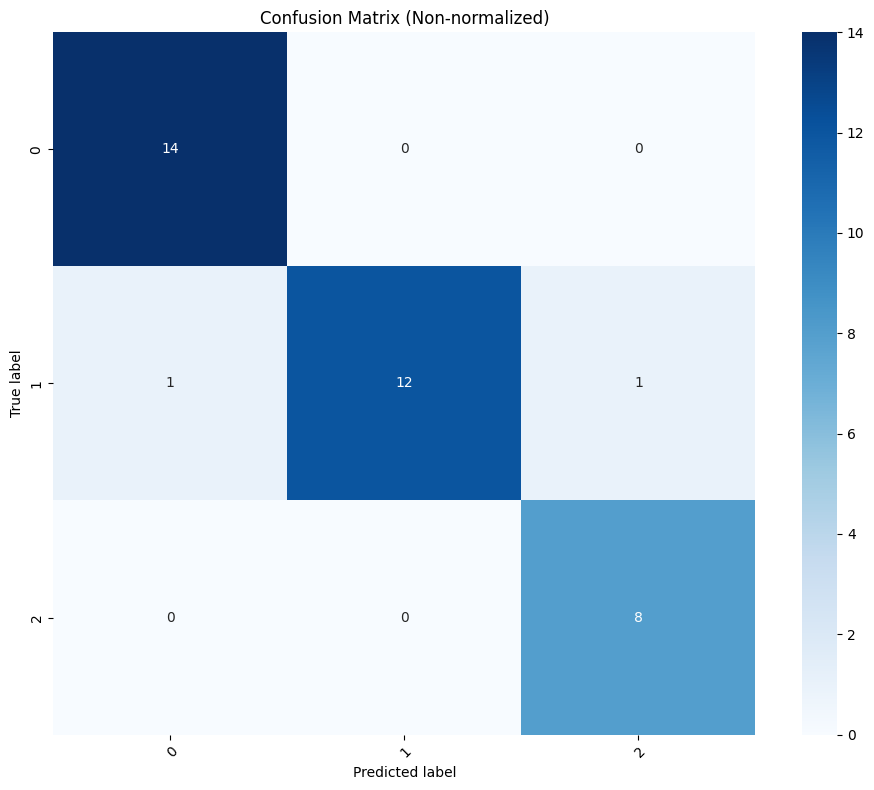

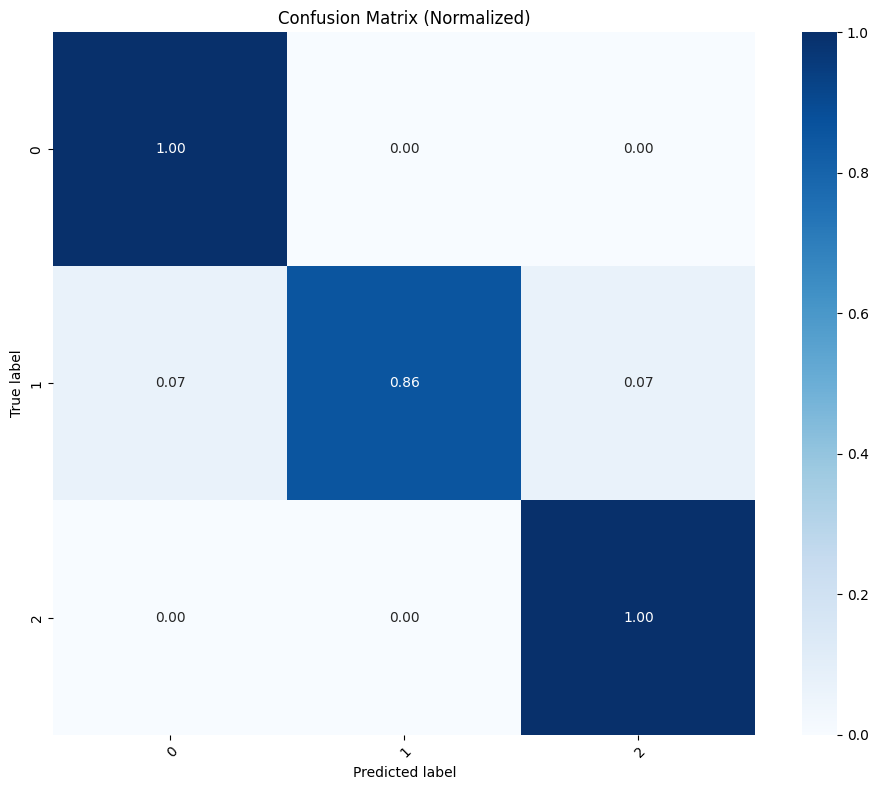

In [78]:
exec(plot_code[0])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_decision_boundary(model, X, y, title="Decision Boundary", filename="decision_boundary.png"):
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # Create a mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Make predictions on the mesh grid
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, alpha=0.8)
    plt.title(title)
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.colorbar(scatter)
    
    # Save the plot instead of showing it
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free up memory

# Assuming x_test and y_test are already defined
model = mo.MultiLevelAbstractionKNN(n_neighbors=5, n_levels=3)
model.fit(x_test, y_test)
plot_decision_boundary(model, x_test, y_test, "MultiLevelAbstractionKNN Decision Boundary", "multilevel_abstraction_knn_decision_boundary.png")

KeyboardInterrupt: 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(model1, model2, X, y, title="Decision Boundaries Comparison", filename="decision_boundaries.png"):
    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    
    # Create a mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Make predictions on the mesh grid for both models
    Z1 = model1.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z1 = Z1.reshape(xx.shape)
    
    Z2 = model2.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z2 = Z2.reshape(xx.shape)
    
    # Create custom colormap
    cmap = ListedColormap(['#FF9999', '#66B2FF', '#99FF99'])
    
    # Plot the decision boundaries
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)
    
    # Plot for MultiLevelAbstractionKNN
    im1 = ax1.contourf(xx, yy, Z1, cmap=cmap, alpha=0.8)
    scatter1 = ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=cmap, edgecolor='black', linewidth=1)
    ax1.set_title("MultiLevelAbstractionKNN")
    ax1.set_xlabel("First Principal Component")
    ax1.set_ylabel("Second Principal Component")
    
    # Plot for standard KNN
    im2 = ax2.contourf(xx, yy, Z2, cmap=cmap, alpha=0.8)
    scatter2 = ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=cmap, edgecolor='black', linewidth=1)
    ax2.set_title("Standard KNN")
    ax2.set_xlabel("First Principal Component")
    ax2.set_ylabel("Second Principal Component")
    
    # Add legend
    classes = np.unique(y)
    class_names = [f'Class {i}' for i in classes]
    legend1 = ax1.legend(scatter1.legend_elements()[0], class_names, 
                         loc="lower right", title="Classes")
    ax1.add_artist(legend1)
    
    legend2 = ax2.legend(scatter2.legend_elements()[0], class_names, 
                         loc="lower right", title="Classes")
    ax2.add_artist(legend2)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Assuming x_test and y_test are already defined
model1 = mo.MultiLevelAbstractionKNN(n_neighbors=5, n_levels=3)
model1.fit(x_test, y_test)
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(x_test, y_test)
plot_decision_boundaries(model1, model2, x_test, y_test, "MultiLevelAbstractionKNN vs Standard KNN")